# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

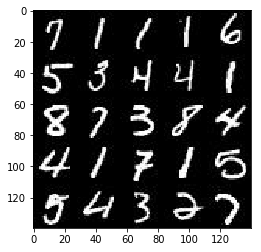

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

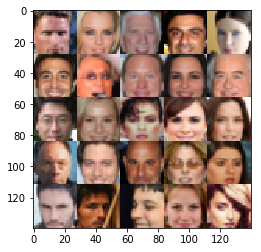

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    tensor_realinput = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels),
                                        name = 'realinput')
    tensor_zdata = tf.placeholder(tf.float32, shape = (None, z_dim), name = 'zdata')
    tensor_lr = tf.placeholder(tf.float32, shape = None, name = 'lr')

    return(tensor_realinput, tensor_zdata, tensor_lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse = False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        layer_input = images
        
        layer_hidden_1_input = tf.layers.conv2d(layer_input, 64, 5, strides = 2, padding = 'same')
        layer_hidden_1_output = tf.maximum(0.2 * layer_hidden_1_input, layer_hidden_1_input)
        
        layer_hidden_2_input = tf.layers.batch_normalization(tf.layers.conv2d(layer_hidden_1_output, 
                                                                              128, 5, strides = 2, padding = 'same'))
        layer_hidden_2_output = tf.maximum(0.2 * layer_hidden_2_input, layer_hidden_2_input)
        
        layer_hidden_3_input = tf.layers.batch_normalization(tf.layers.conv2d(layer_hidden_2_output, 
                                                                              256, 5, strides = 2, padding = 'same'))
        layer_hidden_3_output = tf.maximum(0.2 * layer_hidden_3_input, layer_hidden_3_input)
        
        layer_output_input = tf.layers.dense(tf.reshape(layer_hidden_3_output, (-1, 4 * 4 * 256)), 1)
        layer_output_output = tf.sigmoid(layer_output_input)
        
    return(layer_output_output, layer_output_input)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    flag = not is_train
    with tf.variable_scope('generator', reuse = flag):
        layer_input = z
        
        layer_hidden_1_input = tf.layers.batch_normalization(tf.reshape(tf.layers.dense(layer_input, 2 * 2 * 512), (-1, 2, 2, 512)),
                                                              training = is_train)
        layer_hidden_1_output = tf.maximum(0.2 * layer_hidden_1_input, layer_hidden_1_input)
        
        layer_hidden_2_input = tf.layers.batch_normalization(tf.layers.conv2d_transpose(layer_hidden_1_output, 
                                                                                        256, 5, strides = 2, padding = 'valid'), training = is_train)
        layer_hidden_2_output = tf.maximum(0.2 * layer_hidden_2_input, layer_hidden_2_input)
        
        layer_hidden_3_input = tf.layers.batch_normalization(tf.layers.conv2d_transpose(layer_hidden_2_output, 
                                                                                        128, 5, strides = 2, padding = 'same'), training = is_train)
        layer_hidden_3_output = tf.maximum(0.2 * layer_hidden_3_input, layer_hidden_3_input)
        
        layer_output_input = tf.layers.conv2d_transpose(layer_hidden_3_output, out_channel_dim, 5, strides = 2, padding = 'same')
        layer_output_output = tf.tanh(layer_output_input)
    
        return(layer_output_output)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse = True)
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_real,
                                                                            labels = tf.ones_like(dis_model_real)))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake, 
                                                                             labels = tf.zeros_like(dis_model_fake)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake, 
                                                                        labels = tf.ones_like(dis_model_fake)))
    dis_loss = dis_loss_real + dis_loss_fake

    return(dis_loss, gen_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    dis_vars = [ x for x in tf.trainable_variables() if x.name.startswith('discriminator') ]
    gen_vars = [ x for x in tf.trainable_variables() if x.name.startswith('generator') ]
    
    dis_opt = tf.train.AdamOptimizer(
                learning_rate, beta1 = beta1).minimize(d_loss, var_list = dis_vars)
    
    opts = [ x for x in tf.get_collection(tf.GraphKeys.UPDATE_OPS) if x.name.startswith('generator') ]
    with tf.control_dependencies(opts):
        gen_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list = gen_vars)
        
    return(dis_opt, gen_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    session, width, height, channel = data_shape
    realinput, zinput, lr = model_inputs(width, height, channel, z_dim)
    dis_loss, gen_loss = model_loss(realinput, zinput, channel)
    dis_opt, gen_opt = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    count = 0    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                count += 1
                batch_images *= 2
                zinput_val = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                session = sess.run(dis_opt, feed_dict={realinput: batch_images, 
                                                        zinput: zinput_val, 
                                                        lr: learning_rate})
                session = sess.run(gen_opt, feed_dict={zinput: zinput_val, 
                                                        lr: learning_rate})
                
                if count % 100 == 0:
                    train_loss_dis = dis_loss.eval({zinput: zinput_val, realinput: batch_images})
                    train_loss_gen = gen_loss.eval({zinput: zinput_val})
                    print("Epoch {}, DisLoss: {:.4f}, GenLoss: {:.4f}".format(epoch_i, 
                                                                              train_loss_dis, train_loss_gen))
                    show_generator_output(sess, 25, zinput, channel, data_image_mode)
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 0, DisLoss: 0.7510, GenLoss: 1.0550


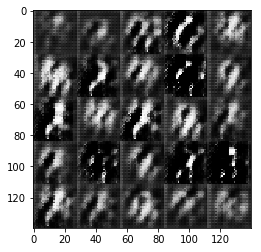

Epoch 0, DisLoss: 0.9914, GenLoss: 1.7206


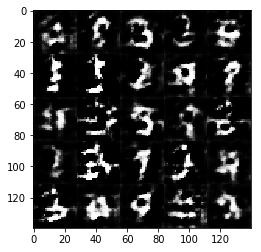

Epoch 0, DisLoss: 0.8226, GenLoss: 1.4833


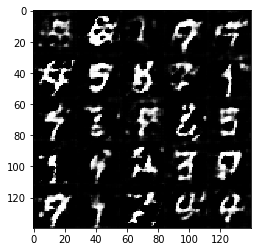

Epoch 0, DisLoss: 1.2780, GenLoss: 0.5064


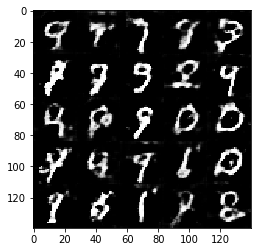

Epoch 0, DisLoss: 0.2177, GenLoss: 101.0235


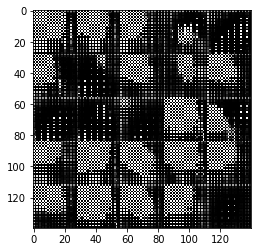

Epoch 0, DisLoss: 3.5963, GenLoss: 16.6865


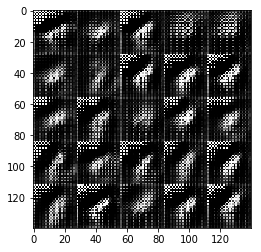

Epoch 0, DisLoss: 0.4190, GenLoss: 6.4418


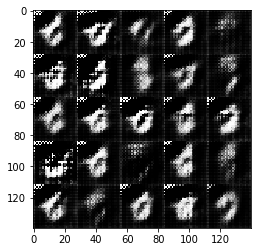

Epoch 0, DisLoss: 1.0089, GenLoss: 4.7369


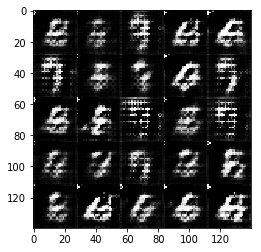

Epoch 0, DisLoss: 1.4013, GenLoss: 0.7613


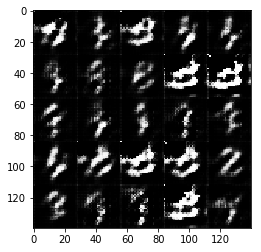

Epoch 1, DisLoss: 1.3704, GenLoss: 4.0441


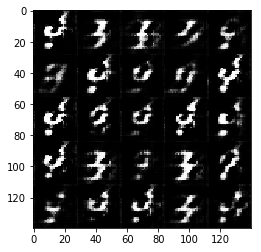

Epoch 1, DisLoss: 0.4792, GenLoss: 1.9935


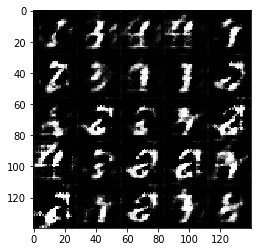

Epoch 1, DisLoss: 0.5629, GenLoss: 1.9082


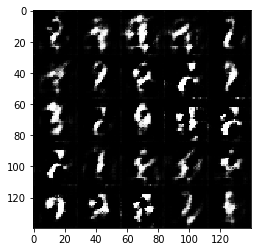

Epoch 1, DisLoss: 0.7768, GenLoss: 1.8197


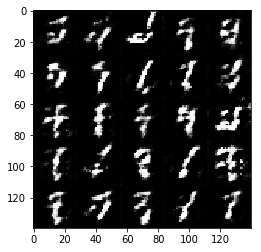

Epoch 1, DisLoss: 0.6096, GenLoss: 2.1550


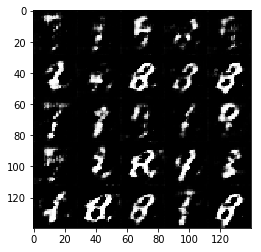

Epoch 1, DisLoss: 0.8122, GenLoss: 0.9496


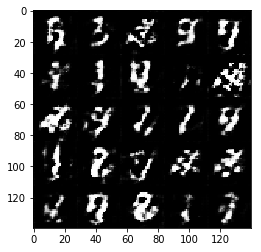

Epoch 1, DisLoss: 0.5738, GenLoss: 1.2894


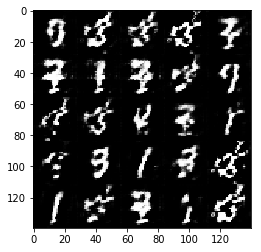

Epoch 1, DisLoss: 2.8011, GenLoss: 0.8316


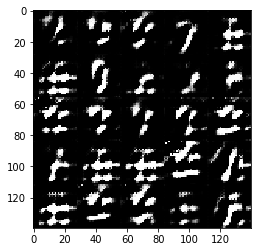

Epoch 1, DisLoss: 1.2760, GenLoss: 0.7139


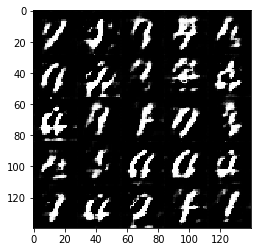

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 0, DisLoss: 0.8886, GenLoss: 1.2989


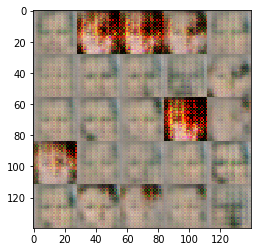

Epoch 0, DisLoss: 1.0804, GenLoss: 0.8176


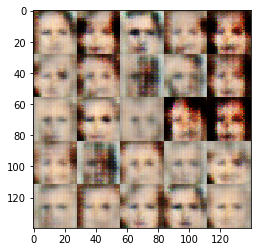

Epoch 0, DisLoss: 1.1342, GenLoss: 0.8975


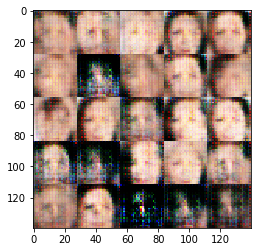

Epoch 0, DisLoss: 1.3690, GenLoss: 0.5004


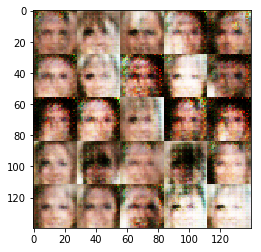

Epoch 0, DisLoss: 1.4203, GenLoss: 0.5685


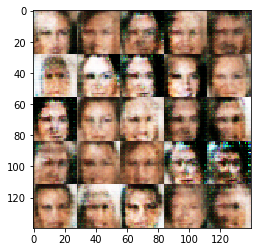

Epoch 0, DisLoss: 1.2724, GenLoss: 0.6744


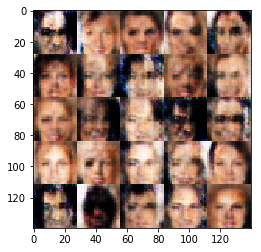

Epoch 0, DisLoss: 1.3979, GenLoss: 0.5962


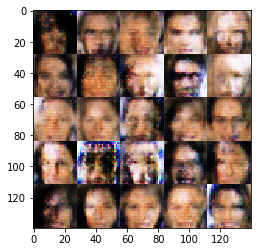

Epoch 0, DisLoss: 1.1732, GenLoss: 0.9548


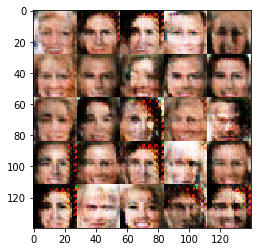

Epoch 0, DisLoss: 1.2636, GenLoss: 0.7399


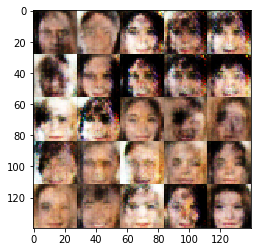

Epoch 0, DisLoss: 1.1936, GenLoss: 1.0926


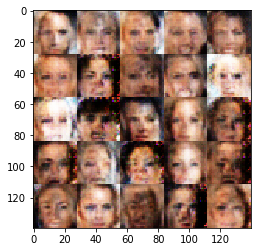

Epoch 0, DisLoss: 1.2728, GenLoss: 1.0880


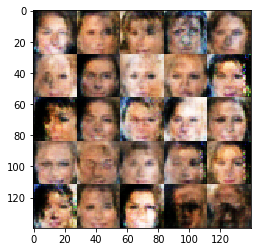

Epoch 0, DisLoss: 1.3768, GenLoss: 91.0628


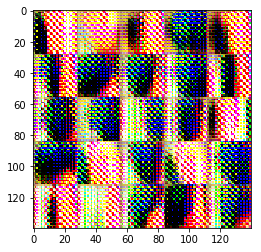

Epoch 0, DisLoss: 1.0969, GenLoss: 20.7194


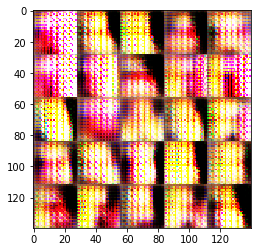

Epoch 0, DisLoss: 1.0379, GenLoss: 7.7293


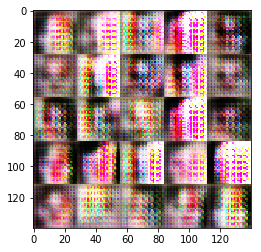

Epoch 0, DisLoss: 1.9118, GenLoss: 8.0633


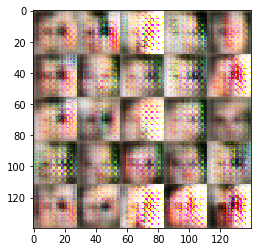

Epoch 0, DisLoss: 0.8396, GenLoss: 9.1439


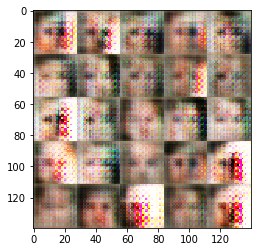

Epoch 0, DisLoss: 1.7312, GenLoss: 2.8905


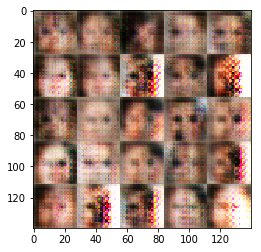

Epoch 0, DisLoss: 0.5219, GenLoss: 3.2385


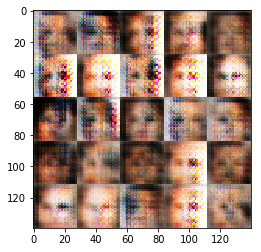

Epoch 0, DisLoss: 1.2356, GenLoss: 1.3532


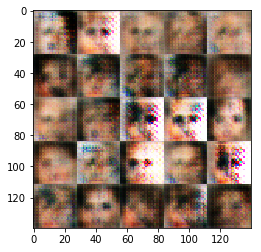

Epoch 0, DisLoss: 0.8152, GenLoss: 2.8793


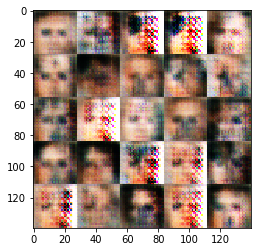

Epoch 0, DisLoss: 1.2556, GenLoss: 1.3852


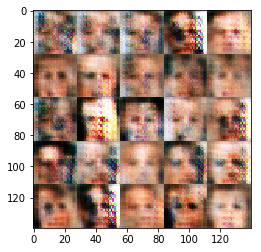

Epoch 0, DisLoss: 0.8675, GenLoss: 1.4402


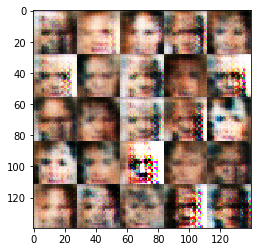

Epoch 0, DisLoss: 0.9009, GenLoss: 2.7021


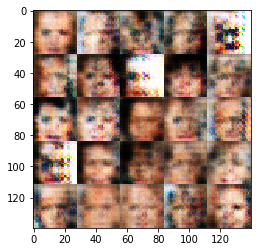

Epoch 0, DisLoss: 1.1886, GenLoss: 1.1795


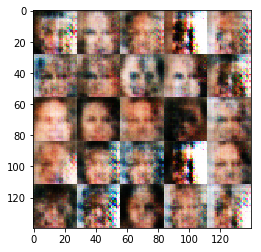

Epoch 0, DisLoss: 1.1888, GenLoss: 3.7822


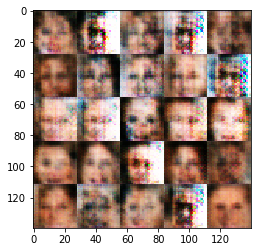

Epoch 0, DisLoss: 1.1309, GenLoss: 2.7473


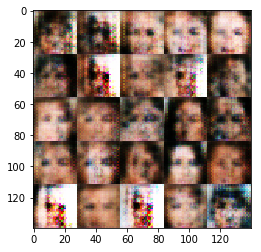

Epoch 0, DisLoss: 0.6174, GenLoss: 2.8467


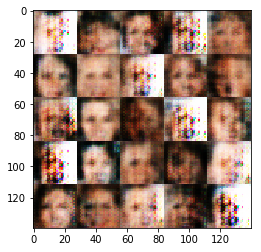

Epoch 0, DisLoss: 0.6654, GenLoss: 2.4706


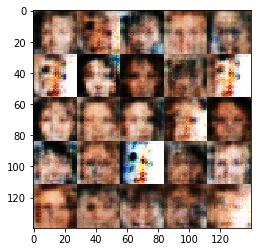

Epoch 0, DisLoss: 0.5540, GenLoss: 3.0862


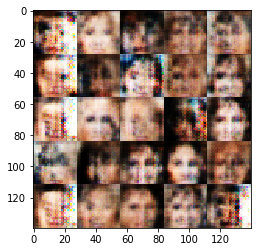

Epoch 0, DisLoss: 0.9434, GenLoss: 1.3188


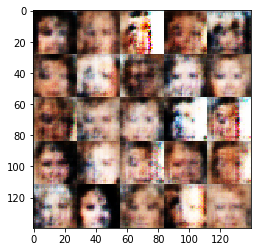

Epoch 0, DisLoss: 0.6954, GenLoss: 2.8530


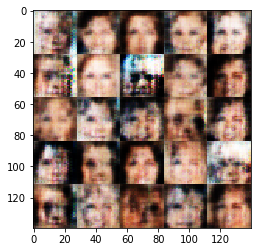

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。